In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
import csv
import math

# Util functions

In [2]:
def save_csv_metrics(data_df, path_file):
    print("Save: ", path_file)
    data_df.to_csv(path_file, sep=',',encoding='utf-8')

# Initial configuration

### Paths

In [3]:
path_networks = 'networks/'
path_degradation_sequences = 'degradation_sequences/'
path_robustness_metrics = 'results/robustness_metrics/'
path_robustness_plots = 'images/plots/robustness_metrics/'

### Configuration variables

In [4]:
l_max =  [1,2,4,8,16,32]

# Read networks

### Read a network

In [5]:
def read_network(path_network):
    if exists(path_network):
        print("Reading network ", path_network)
        G = nx.read_gexf(path_network)
        return G
    else:
        print("The network does not exist ", path_network)
        return None

### Store networks in a dictionary

In [6]:
def get_networks_dictionary(path_networks):
    nets_dict = dict()
    for rule in (1,2):
        nets_dict[rule] = dict()
        for lmax in l_max:
            nets_dict[rule][lmax] = dict()
            for experiment in range(1,11):
                file_network  = 'r' + str(rule) + '_lmaxL'+ str(lmax) + '_experiment' + str(experiment) + '.gexf'
                path_network = path_networks + file_network
                if exists(path_network):
                   nets_dict[rule][lmax][experiment] = read_network(path_network)
    return nets_dict

In [7]:
nets_dict = get_networks_dictionary(path_networks)

Reading network  networks/r1_lmaxL1_experiment1.gexf
Reading network  networks/r1_lmaxL1_experiment2.gexf
Reading network  networks/r1_lmaxL1_experiment3.gexf
Reading network  networks/r1_lmaxL1_experiment4.gexf
Reading network  networks/r1_lmaxL1_experiment5.gexf
Reading network  networks/r1_lmaxL1_experiment6.gexf
Reading network  networks/r1_lmaxL1_experiment7.gexf
Reading network  networks/r1_lmaxL1_experiment8.gexf
Reading network  networks/r1_lmaxL1_experiment9.gexf
Reading network  networks/r1_lmaxL1_experiment10.gexf
Reading network  networks/r1_lmaxL2_experiment1.gexf
Reading network  networks/r1_lmaxL2_experiment2.gexf
Reading network  networks/r1_lmaxL2_experiment3.gexf
Reading network  networks/r1_lmaxL2_experiment4.gexf
Reading network  networks/r1_lmaxL2_experiment5.gexf
Reading network  networks/r1_lmaxL2_experiment6.gexf
Reading network  networks/r1_lmaxL2_experiment7.gexf
Reading network  networks/r1_lmaxL2_experiment8.gexf
Reading network  networks/r1_lmaxL2_experimen

# Compute, plot and save robusteness metrics

### Plot and save robustness metrics

In [8]:
def plot_distribution(series, std, title, xlabel, ylabel, file_image):
    plt.errorbar(series[1][0], series[1][1], yerr=std[1], fmt="o")
    plt.errorbar(series[2][0], series[2][1], yerr=std[2], fmt="o")
    plt.scatter(series[1][0], series[1][1], label='R1')
    plt.scatter(series[2][0], series[2][1], label='R2')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')
    print('Save ', file_image)
    plt.savefig(file_image, format='eps')
    plt.show()

In [9]:
def plot_metric_normal_scale(series, std, title, xlabel, ylabel, file_image):
    plt.errorbar(series[1][0], series[1][1], yerr=std[1], fmt="o")
    plt.errorbar(series[2][0], series[2][1], yerr=std[2], fmt="o")
    plt.scatter(series[1][0], series[1][1], label='R1')
    plt.scatter(series[2][0], series[2][1], label='R2')
    plt.xticks([6,5,4,3,2,1], ['L','L/2','L/4','L/8','L/16', 'L/32'])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')
    plt.ylim((0,1))
    print('Save ', file_image)
    plt.savefig(file_image, format='eps')
    plt.show()

### Compute A2TR

In [10]:
def compute_AT2R(comp_dist, n):
    num_paths = [i*(i-1) for i in comp_dist if i>1]
    if len(num_paths) == 0:
        return 0
    else:
        return sum(num_paths) / (n*(n-1)) 

### Get the clusters list

In [11]:
def get_clusters_list(G):
    return [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

### Compute network metrics

In [12]:
def compute_robustness(G, removed_nodes):
    H = G.copy()
    remain_nodes = [0]
    rolcc_s0 = [1]
    rolcc_si = [1]
    attr = [1]
    for i in range(100):
        #degradate the network
        rnodes = removed_nodes[i*25:(i*25+25)]
        H.remove_nodes_from(rnodes)
        num_nodes = len(H.nodes())
        remain_nodes.append(((i+1)*25)/2500)
        clusters_list = get_clusters_list(H)
        rolcc_s0.append(max(clusters_list) / 2500)
        rolcc_si.append(max(clusters_list) / num_nodes)
        a2tr = compute_AT2R(clusters_list, num_nodes)
        attr.append(a2tr)
    data = {'remain_nodes': remain_nodes, 'rolcc_s0': rolcc_s0, 'rolcc_si':rolcc_si, 'attr': attr}
    df_robustness =pd.DataFrame.from_dict(data)
    return df_robustness

In [16]:
def compute_mean_robustness(nets_dict, path_degradation_sequences, path_robustness_metrics, path_robustness_plots):
    for degradation in ["failures", "attacks"]:
        if degradation == "failures":
            degradation_seq = range(1,11)
        else:
            degradation_seq = [1]
        mean = {'f*_s0':dict(), 'f*_si':dict(), 'mattr': dict(), 'r': dict()}
        std = {'f*_s0':dict(), 'f*_si':dict(), 'mattr': dict(), 'r': dict()}
        mean_rolcc_s0_dist = dict()
        std_rolcc_s0_dist = dict()
        mean_rolcc_si_dist = dict()
        std_rolcc_si_dist = dict()
        for rule in (1,2):       
            results_robustness = {'experiment':[], 'l_max':[], 'degradation_seq':[], 'f*_s0':[], 'f*_si':[], 'mattr':[], 'r':[]}
            path_robustness = path_robustness_metrics + 'robustness_' + degradation + '_r' + str(rule) + '.csv'
            mean_rolcc_s0_dist[rule] = dict()
            std_rolcc_s0_dist[rule] = dict()
            mean_rolcc_si_dist[rule] = dict()
            std_rolcc_si_dist[rule] = dict()
            for lmax in l_max:
                results_clusters = {'experiment':[],  'degradation_seq':[], 'rolcc_s0':[], 'rolcc_si':[], 'f':[]}
                path_rolcc_s0 = path_robustness_metrics + 'rolcc_s0/' + degradation + '_rolcc_s0_r' + str(rule) + '_lmaxL' + str(lmax) + '.csv'
                path_rolcc_si = path_robustness_metrics + 'rolcc_si/' + degradation + '_rolcc_si_r' + str(rule) + '_lmaxL' + str(lmax) + '.csv'
                for experiment in range(1,11):
                    for s in degradation_seq:
                        path_seq = path_degradation_sequences + degradation + '_sequences/r' + str(rule) + '_lmaxL' + str(lmax) + '_e' + str(experiment) + '_' + degradation + 'Sequence' + str(s) + '.txt'
                        if experiment in nets_dict[rule][lmax].keys() and exists(path_seq):
                            # read the degradation nodes sequence
                            file_degradation_seq = open(path_seq, "r") 
                            data = file_degradation_seq.read() 
                            rnodes = data.split("\n")
                            removed_nodes = [i for i in rnodes if i]
                            # Compute robustness
                            G = nets_dict[rule][lmax][experiment]
                            # Save robustness metric
                            df_robustness = compute_robustness(G, removed_nodes)
                            results_robustness['experiment'].append(experiment)
                            results_robustness['l_max'].append(lmax)
                            results_robustness['degradation_seq'].append(s)
                            # Compute Robustness Index
                            r = df_robustness['rolcc_si'].mean()
                            results_robustness['r'].append(r)
                            # Compute m-AT2R
                            mattr = df_robustness['attr'].mean()
                            results_robustness['mattr'].append(mattr)
                            #  fc with respect s0
                            fc_s0 = max([i for i in range(100) if list(df_robustness['rolcc_s0'])[i] > 0.5]) / 100
                            results_robustness['f*_s0'].append(fc_s0)
                            #  fc with respect si
                            fc_si = max([i for i in range(100) if list(df_robustness['rolcc_si'])[i] > 0.5]) / 100
                            results_robustness['f*_si'].append(fc_si)
                            # Save cluster distributions
                            rolcc_s0 = list(df_robustness['rolcc_s0'])
                            rolcc_si = list(df_robustness['rolcc_si'])
                            f = list(df_robustness['remain_nodes'])
                            results_clusters['experiment'].extend([experiment]*len(rolcc_s0))
                            results_clusters['degradation_seq'].extend([s]*len(rolcc_s0))
                            results_clusters['rolcc_s0'].extend(rolcc_s0)
                            results_clusters['rolcc_si'].extend(rolcc_si)
                            results_clusters['f'].extend(f)
                rolcc_df  = pd.DataFrame.from_dict(results_clusters)
                # Save cluster distirbutions with respect s0
                rolcc_dist = pd.DataFrame()
                rolcc_dist['N_LCC_s0_mean'] = rolcc_df.groupby('f')['rolcc_s0'].mean()
                rolcc_dist['N_LCC_s0_std'] = rolcc_df.groupby('f')['rolcc_s0'].std()
                rolcc_dist = rolcc_dist.fillna(0)
                save_csv_metrics(rolcc_dist, path_rolcc_s0)
                mean_rolcc_s0_dist[rule][lmax] = (list(rolcc_dist.index),list(rolcc_dist['N_LCC_s0_mean']))
                std_rolcc_s0_dist[rule][lmax] = list(rolcc_dist['N_LCC_s0_std'])
                # Save cluster distirbutions with respect si
                rolcc_dist = pd.DataFrame()
                rolcc_dist['N_LCC_si_mean'] = rolcc_df.groupby('f')['rolcc_si'].mean()
                rolcc_dist['N_LCC_si_std'] = rolcc_df.groupby('f')['rolcc_si'].std()
                rolcc_dist = rolcc_dist.fillna(0)
                save_csv_metrics(rolcc_dist, path_rolcc_si)
                mean_rolcc_si_dist[rule][lmax] = (list(rolcc_dist.index),list(rolcc_dist['N_LCC_si_mean']))
                std_rolcc_si_dist[rule][lmax] = list(rolcc_dist['N_LCC_si_std'])
                
            results_df  = pd.DataFrame.from_dict(results_robustness)
            robustness = pd.DataFrame()
            robustness['f*_s0_mean'] = results_df.groupby('l_max')['f*_s0'].mean()
            robustness['f*_s0_std'] = results_df.groupby('l_max')['f*_s0'].std()
            robustness['f*_si_mean'] = results_df.groupby('l_max')['f*_si'].mean()
            robustness['f*_si_std'] = results_df.groupby('l_max')['f*_si'].std()
            robustness['r_mean'] = results_df.groupby('l_max')['r'].mean()
            robustness['r_std'] = results_df.groupby('l_max')['r'].std()
            robustness['mattr_mean'] = results_df.groupby('l_max')['mattr'].mean()
            robustness['mattr_std'] = results_df.groupby('l_max')['mattr'].std()
            save_csv_metrics(robustness, path_robustness)
            mean['f*_s0'][rule] = ([6,5,4,3,2,1],list(robustness['f*_s0_mean']))
            std['f*_s0'][rule] = list(robustness['f*_s0_std'])
            mean['f*_si'][rule] = ([6,5,4,3,2,1],list(robustness['f*_si_mean']))
            std['f*_si'][rule] = list(robustness['f*_si_std'])
            mean['r'][rule] = ([6,5,4,3,2,1],list(robustness['r_mean']))
            std['r'][rule] = list(robustness['r_std'])
            mean['mattr'][rule] = ([6,5,4,3,2,1],list(robustness['mattr_mean']))
            std['mattr'][rule] = list(robustness['mattr_std'])
            
        # Plot robustness metrics
        plot_metric_normal_scale(mean['f*_s0'], 
                   std['f*_s0'], 
                   "Critical point (" + degradation + ")", 
                   'l_max',
                   'f*_s0',
                   path_robustness_plots + 'critical_point_s0_' + degradation + '.eps'
                  )  
        plot_metric_normal_scale(mean['f*_si'], 
                   std['f*_si'], 
                   "Critical point (" + degradation + ")", 
                   'l_max',
                   'f*_si',
                   path_robustness_plots + 'critical_point_si_' + degradation + '.eps'
                  ) 
        plot_metric_normal_scale(mean['r'], 
                   std['r'], 
                   "R(" + degradation + ")", 
                   'l_max',
                   'R',
                   path_robustness_plots + 'rindex_' + degradation + '.eps'
                  ) 
        plot_metric_normal_scale(mean['mattr'], 
                   std['mattr'], 
                   "$\mu$-A2TR(" + degradation + ")", 
                   'l_max',
                   '$\mu$-A2TR',
                   path_robustness_plots + 'mattr_' + degradation + '.eps'
                  ) 
        # Plot cluster distribution
        for lmax in l_max:
            mean_cd  = {1: mean_rolcc_s0_dist[1][lmax], 2: mean_rolcc_s0_dist[2][lmax]} 
            std_cd = {1: std_rolcc_s0_dist[1][lmax], 2: std_rolcc_s0_dist[2][lmax]}
            plot_distribution(mean_cd, 
                                  std_cd, 
                                  "Relative order of LCC respect s0 - lmax=L/" + str(lmax) + " (" + degradation + ")", 
                                  'f',
                                  'N_LCC',
                              path_robustness_plots + 'rolcc_s0/rolcc_s0_' + degradation + '_r' + str(rule) + '_lmaxL' + str(lmax) + '.eps') 
        for lmax in l_max:
            mean_cd  = {1: mean_rolcc_si_dist[1][lmax], 2: mean_rolcc_si_dist[2][lmax]} 
            std_cd = {1: std_rolcc_si_dist[1][lmax], 2: std_rolcc_si_dist[2][lmax]}
            plot_distribution(mean_cd, 
                                  std_cd, 
                                  "Relative order of LCC respect si - lmax=L/" + str(lmax) + " (" + degradation + ")", 
                                  'f',
                                  'N_LCC',
                              path_robustness_plots + 'rolcc_si/rolcc_si_' + degradation + '_r' + str(rule) + '_lmaxL' + str(lmax) + '.eps') 

Save:  results/robustness_metrics/rolcc_s0/failures_rolcc_s0_r1_lmaxL1.csv
Save:  results/robustness_metrics/rolcc_si/failures_rolcc_si_r1_lmaxL1.csv
Save:  results/robustness_metrics/rolcc_s0/failures_rolcc_s0_r1_lmaxL2.csv
Save:  results/robustness_metrics/rolcc_si/failures_rolcc_si_r1_lmaxL2.csv
Save:  results/robustness_metrics/rolcc_s0/failures_rolcc_s0_r1_lmaxL4.csv
Save:  results/robustness_metrics/rolcc_si/failures_rolcc_si_r1_lmaxL4.csv
Save:  results/robustness_metrics/rolcc_s0/failures_rolcc_s0_r1_lmaxL8.csv
Save:  results/robustness_metrics/rolcc_si/failures_rolcc_si_r1_lmaxL8.csv
Save:  results/robustness_metrics/rolcc_s0/failures_rolcc_s0_r1_lmaxL16.csv
Save:  results/robustness_metrics/rolcc_si/failures_rolcc_si_r1_lmaxL16.csv
Save:  results/robustness_metrics/rolcc_s0/failures_rolcc_s0_r1_lmaxL32.csv
Save:  results/robustness_metrics/rolcc_si/failures_rolcc_si_r1_lmaxL32.csv
Save:  results/robustness_metrics/robustness_failures_r1.csv
Save:  results/robustness_metrics/r

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save:  results/robustness_metrics/rolcc_s0/failures_rolcc_s0_r2_lmaxL32.csv
Save:  results/robustness_metrics/rolcc_si/failures_rolcc_si_r2_lmaxL32.csv
Save:  results/robustness_metrics/robustness_failures_r2.csv
Save  images/plots/robustness_metrics/critical_point_s0_failures.eps


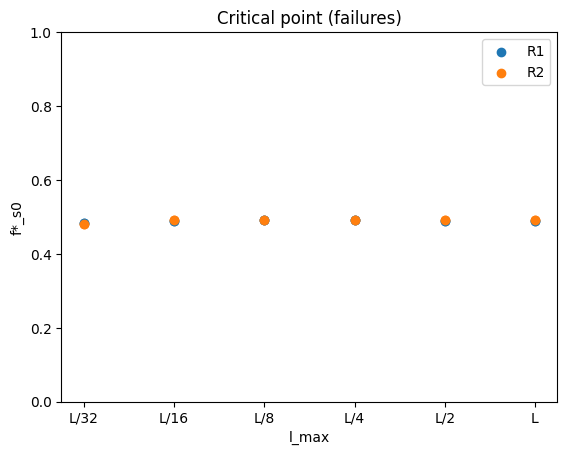

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/critical_point_si_failures.eps


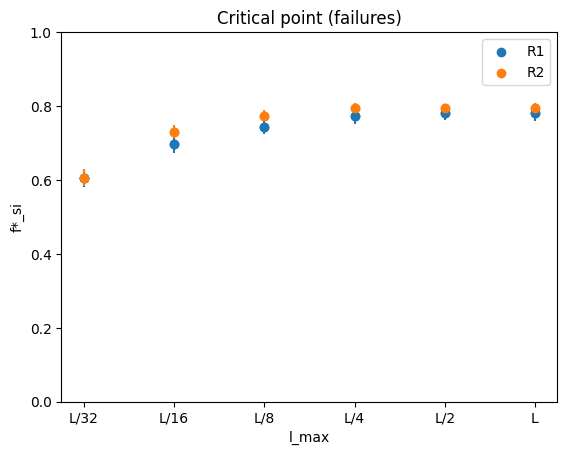

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rindex_failures.eps


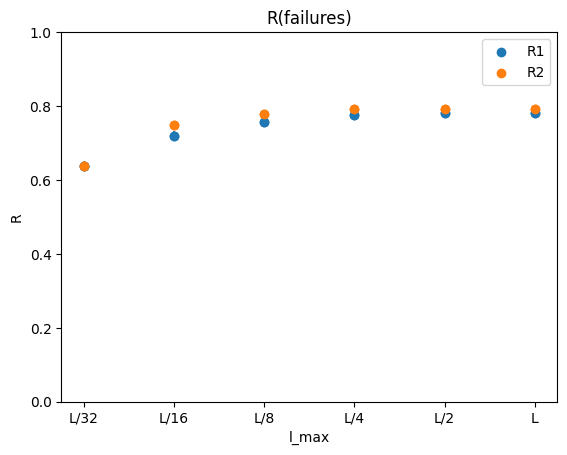

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/mattr_failures.eps


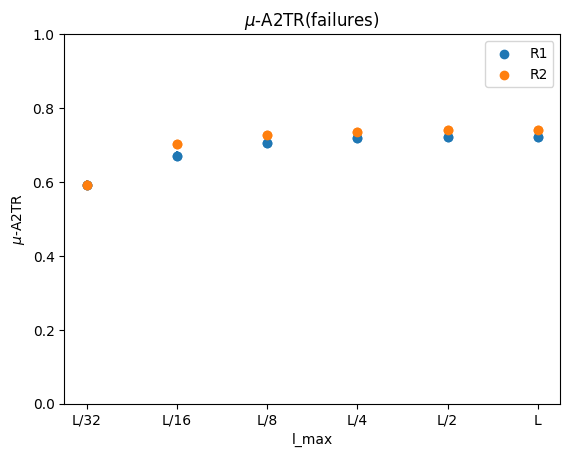

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_s0/rolcc_s0_failures_r2_lmaxL1.eps


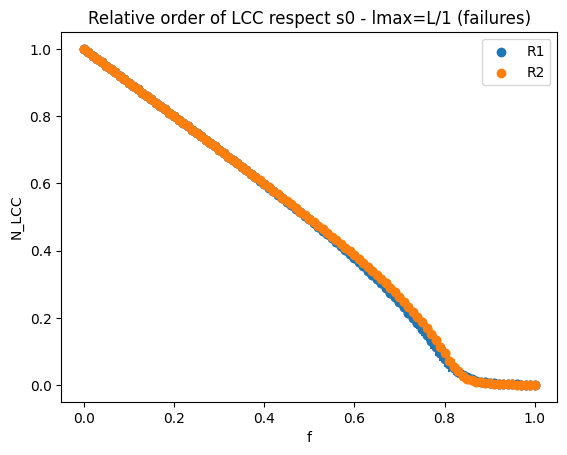

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_s0/rolcc_s0_failures_r2_lmaxL2.eps


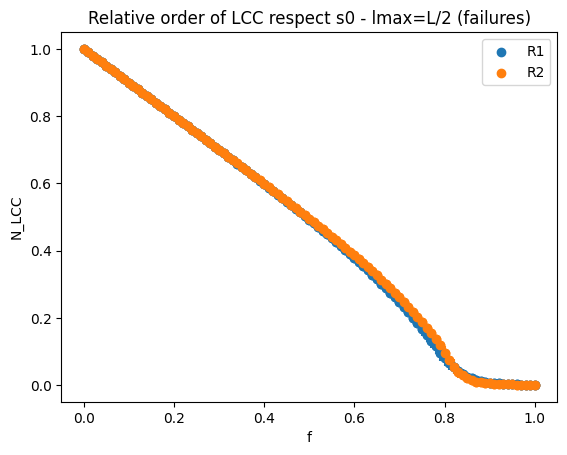

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_s0/rolcc_s0_failures_r2_lmaxL4.eps


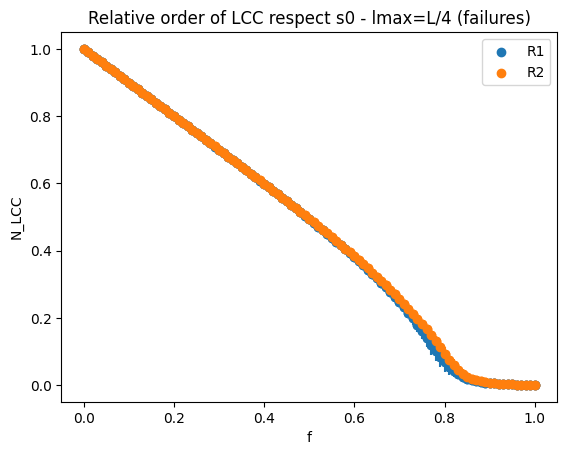

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_s0/rolcc_s0_failures_r2_lmaxL8.eps


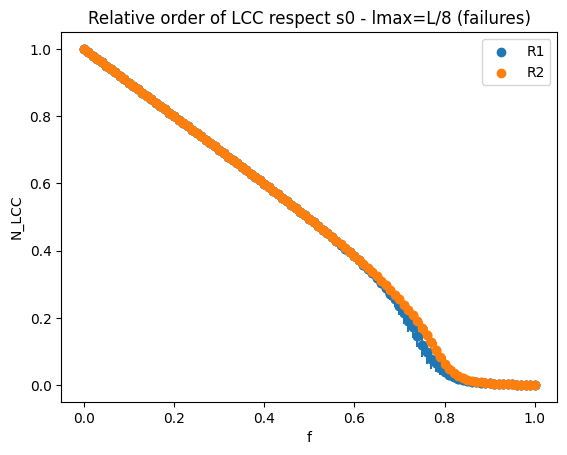

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_s0/rolcc_s0_failures_r2_lmaxL16.eps


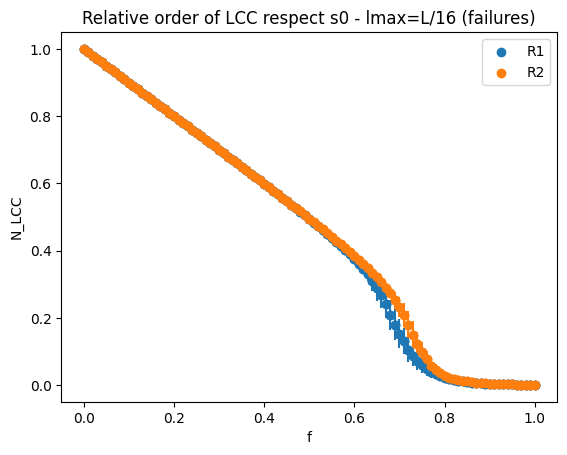

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_s0/rolcc_s0_failures_r2_lmaxL32.eps


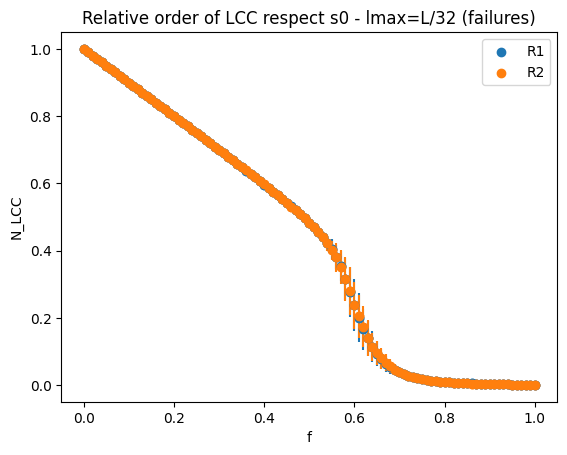

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_si/rolcc_si_failures_r2_lmaxL1.eps


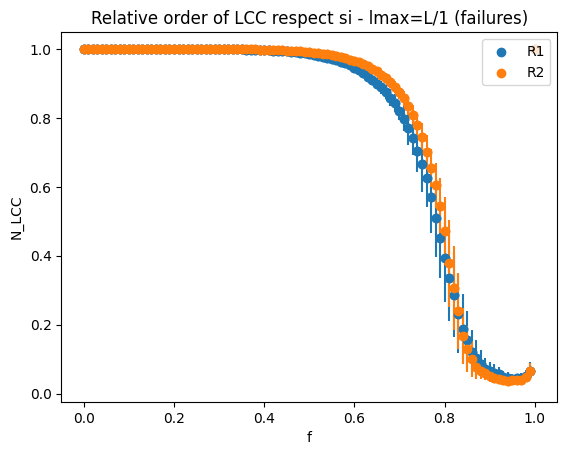

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_si/rolcc_si_failures_r2_lmaxL2.eps


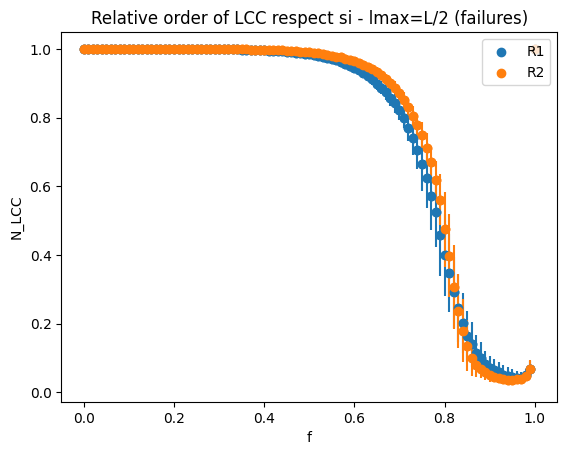

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_si/rolcc_si_failures_r2_lmaxL4.eps


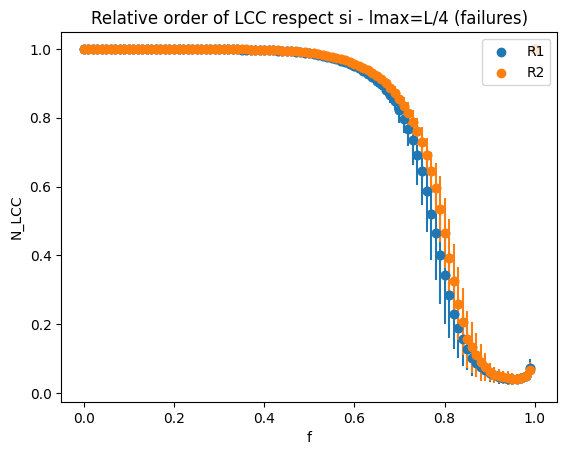

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_si/rolcc_si_failures_r2_lmaxL8.eps


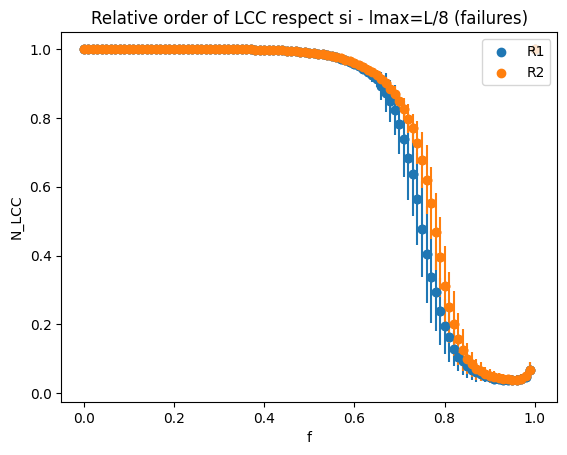

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_si/rolcc_si_failures_r2_lmaxL16.eps


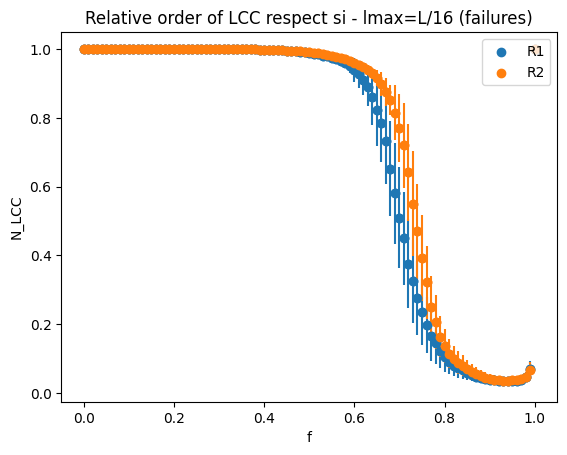

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_si/rolcc_si_failures_r2_lmaxL32.eps


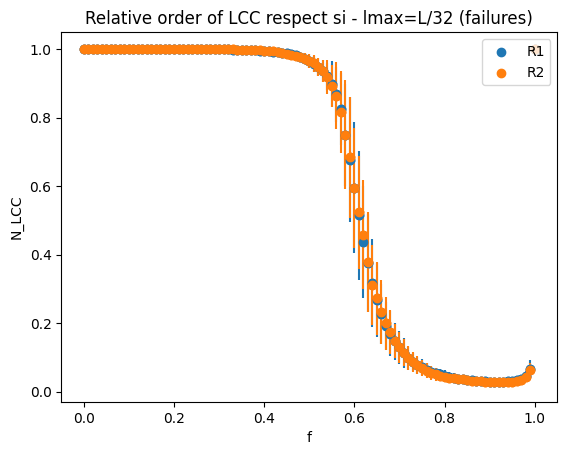

Save:  results/robustness_metrics/rolcc_s0/attacks_rolcc_s0_r1_lmaxL1.csv
Save:  results/robustness_metrics/rolcc_si/attacks_rolcc_si_r1_lmaxL1.csv
Save:  results/robustness_metrics/rolcc_s0/attacks_rolcc_s0_r1_lmaxL2.csv
Save:  results/robustness_metrics/rolcc_si/attacks_rolcc_si_r1_lmaxL2.csv
Save:  results/robustness_metrics/rolcc_s0/attacks_rolcc_s0_r1_lmaxL4.csv
Save:  results/robustness_metrics/rolcc_si/attacks_rolcc_si_r1_lmaxL4.csv
Save:  results/robustness_metrics/rolcc_s0/attacks_rolcc_s0_r1_lmaxL8.csv
Save:  results/robustness_metrics/rolcc_si/attacks_rolcc_si_r1_lmaxL8.csv
Save:  results/robustness_metrics/rolcc_s0/attacks_rolcc_s0_r1_lmaxL16.csv
Save:  results/robustness_metrics/rolcc_si/attacks_rolcc_si_r1_lmaxL16.csv
Save:  results/robustness_metrics/rolcc_s0/attacks_rolcc_s0_r1_lmaxL32.csv
Save:  results/robustness_metrics/rolcc_si/attacks_rolcc_si_r1_lmaxL32.csv
Save:  results/robustness_metrics/robustness_attacks_r1.csv
Save:  results/robustness_metrics/rolcc_s0/attac

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save:  results/robustness_metrics/rolcc_s0/attacks_rolcc_s0_r2_lmaxL32.csv
Save:  results/robustness_metrics/rolcc_si/attacks_rolcc_si_r2_lmaxL32.csv
Save:  results/robustness_metrics/robustness_attacks_r2.csv
Save  images/plots/robustness_metrics/critical_point_s0_attacks.eps


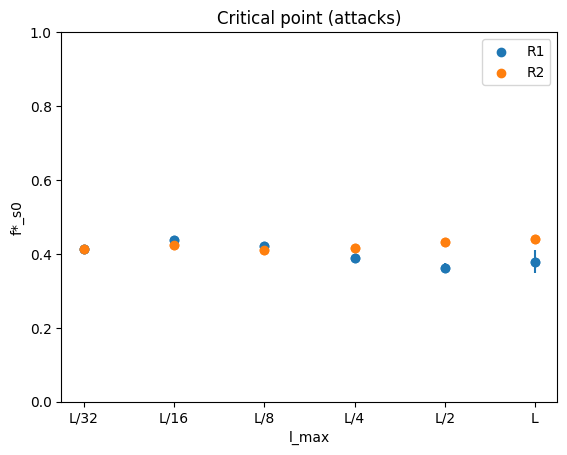

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/critical_point_si_attacks.eps


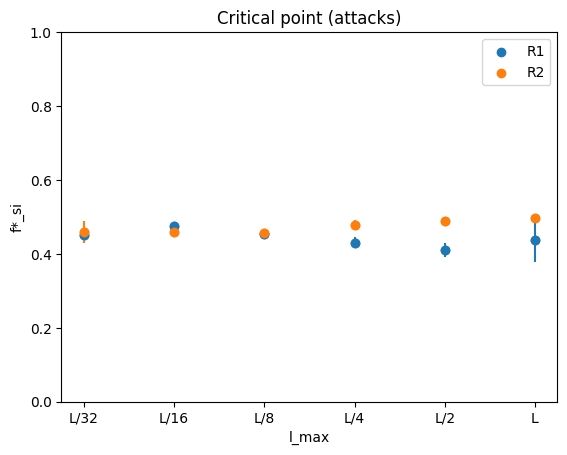

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rindex_attacks.eps


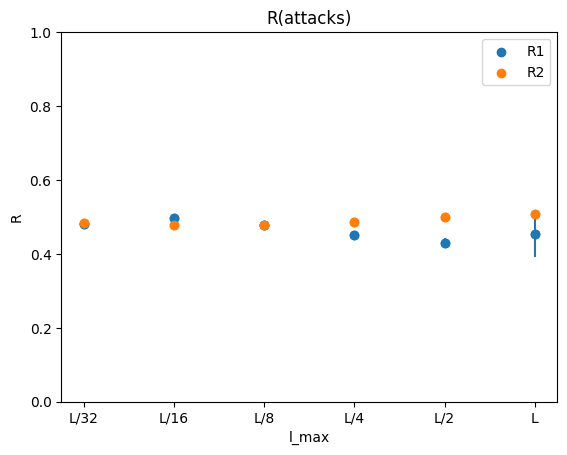

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/mattr_attacks.eps


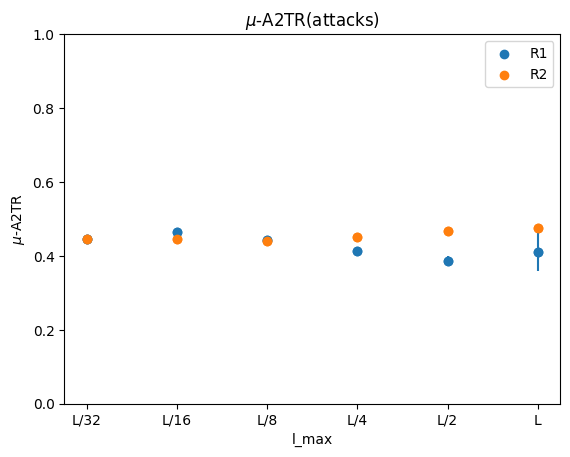

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_s0/rolcc_s0_attacks_r2_lmaxL1.eps


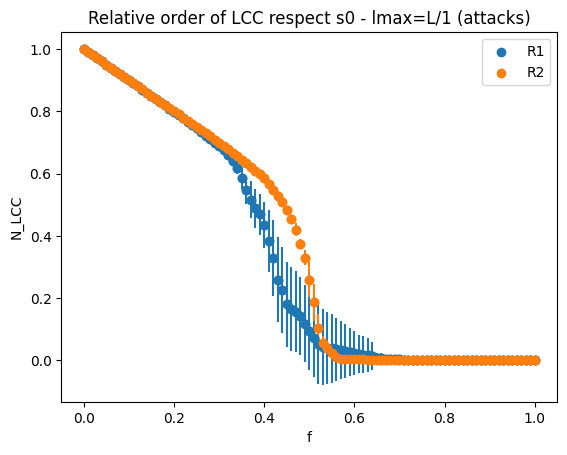

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_s0/rolcc_s0_attacks_r2_lmaxL2.eps


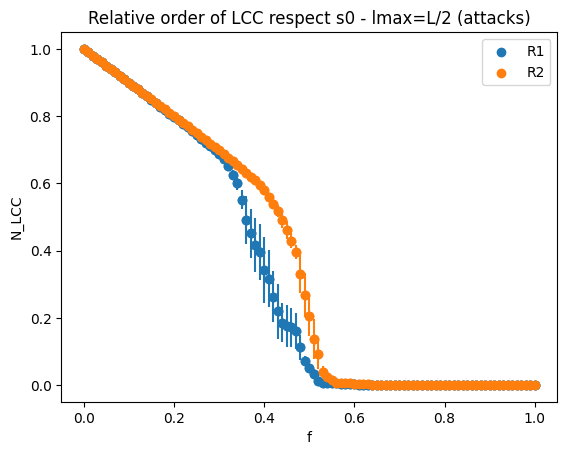

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_s0/rolcc_s0_attacks_r2_lmaxL4.eps


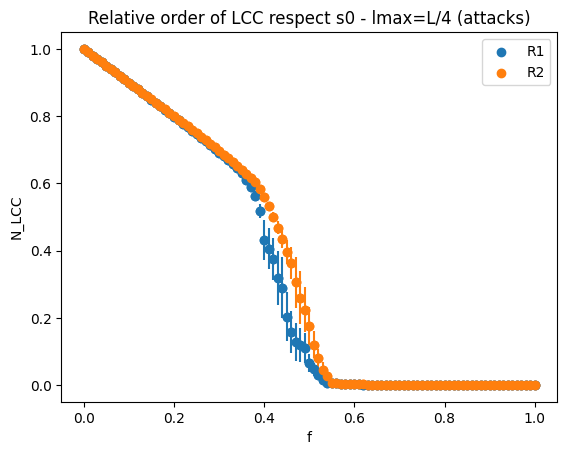

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_s0/rolcc_s0_attacks_r2_lmaxL8.eps


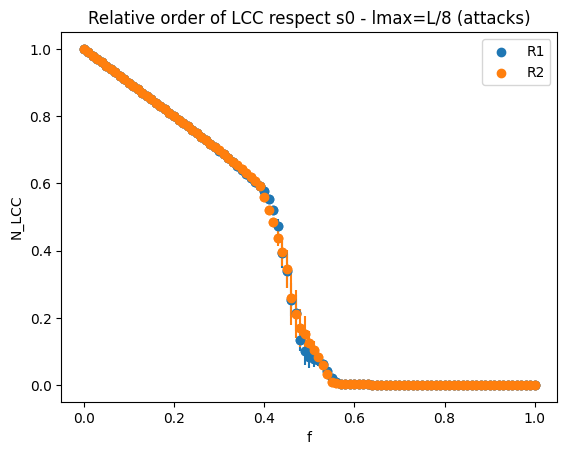

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_s0/rolcc_s0_attacks_r2_lmaxL16.eps


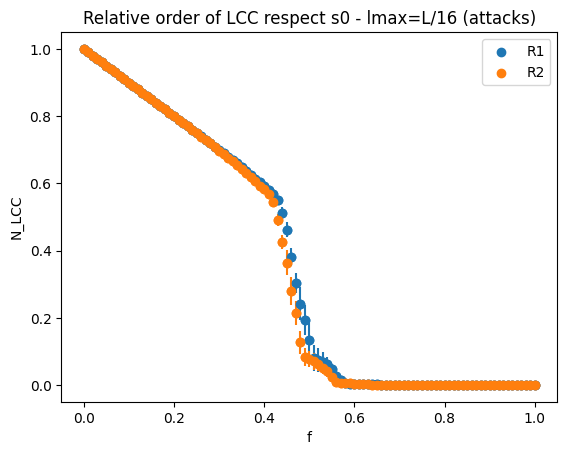

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_s0/rolcc_s0_attacks_r2_lmaxL32.eps


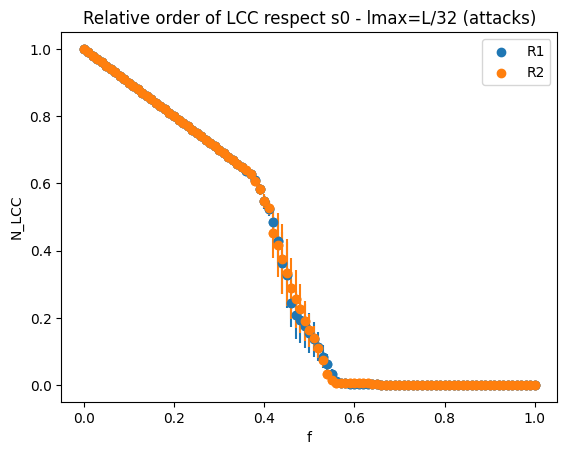

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_si/rolcc_si_attacks_r2_lmaxL1.eps


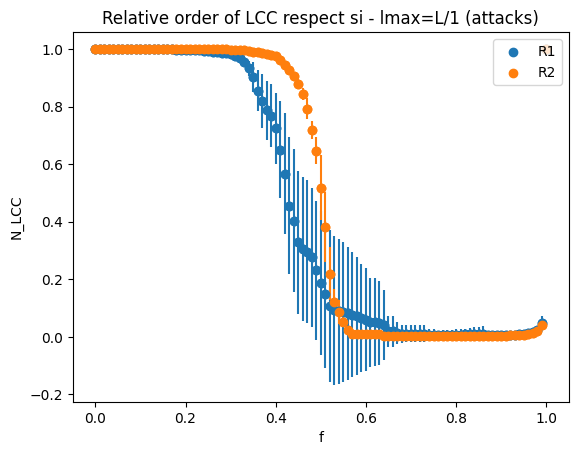

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_si/rolcc_si_attacks_r2_lmaxL2.eps


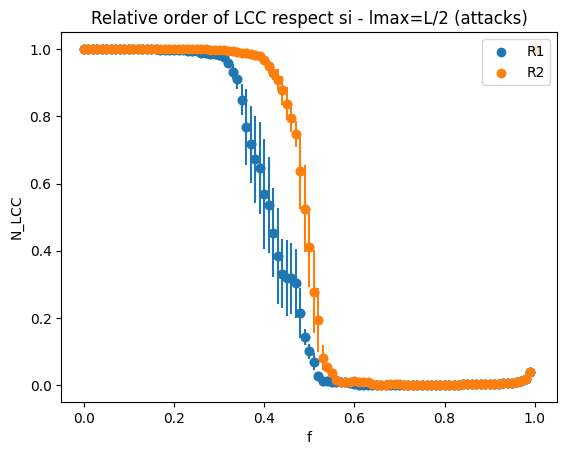

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_si/rolcc_si_attacks_r2_lmaxL4.eps


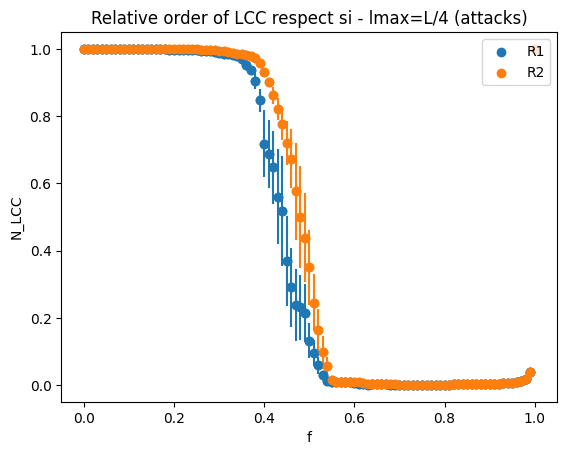

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_si/rolcc_si_attacks_r2_lmaxL8.eps


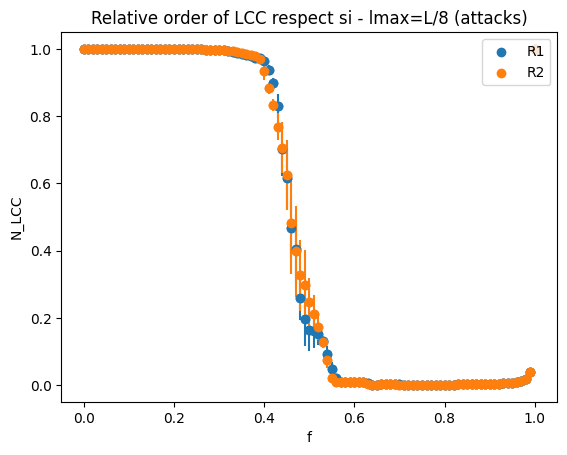

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_si/rolcc_si_attacks_r2_lmaxL16.eps


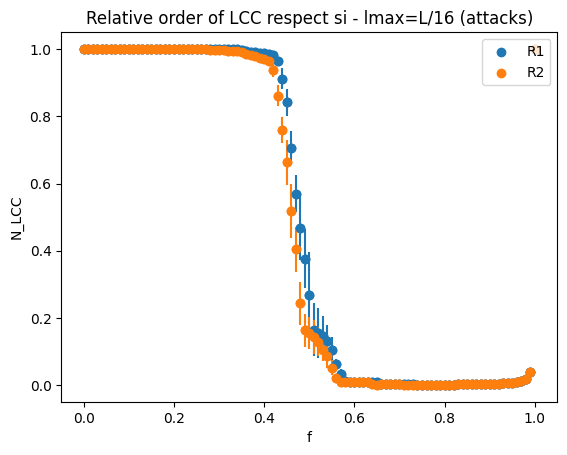

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save  images/plots/robustness_metrics/rolcc_si/rolcc_si_attacks_r2_lmaxL32.eps


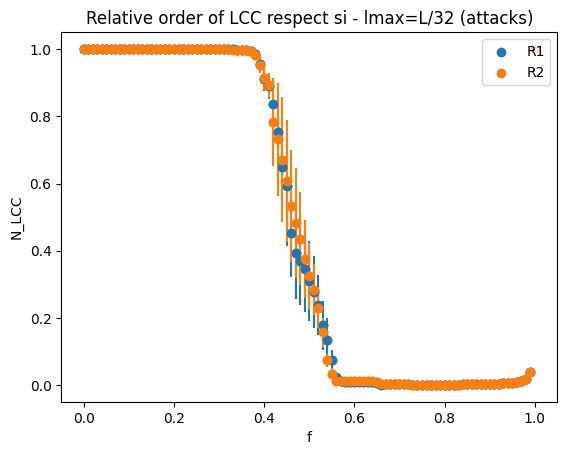

In [17]:
compute_mean_robustness(nets_dict, path_degradation_sequences, path_robustness_metrics, path_robustness_plots)